In [179]:
# ------------------- Import libs ------------------- 
import pandas as pd
import numpy as np
import spacy
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')

# ------------------- Load the datasets ------------------- 
nlp = spacy.load("en_core_web_sm")
product_df = pd.read_csv('/kaggle/input/sdknwef/organic_product_dataset_unique_100.csv')
user_df = pd.read_csv('/kaggle/input/user-click-data-with-age/user_click_data_with_age.csv')

In [180]:
#---------------------Data preprocessing-----------------
for col in ['Rating']:
    product_df[col] = pd.to_numeric(product_df[col], errors='coerce')
    product_df[col].fillna(product_df[col].mean(), inplace=True)


scaler = MinMaxScaler()
product_df[['Rating']] = scaler.fit_transform(product_df[['Rating']])


def spacy_preprocess(text):
    if pd.isnull(text):
        return []
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if not token.is_stop and token.is_alpha:
            tokens.append(token.lemma_)
    return tokens


##-------------------Merge the necessary keywords content columns-------------------------
text_fields = ['Product_Name', 'Ingredients', 'Ayurvedic_Use', 'Description', 'Health_Benefits']
product_df['overall_keytext'] = product_df[text_fields].fillna('').agg(' '.join, axis=1)


##------------Finally preprocessed and tokenization keyworks list append on the dataset separated column as tokens.--------------
token_list = []
for i in range(len(product_df)):
    text = product_df.iloc[i]['overall_keytext']
    tokens = spacy_preprocess(text)
    token_list.append(tokens)
product_df['tokens'] = token_list
print(product_df['overall_keytext'][0])
print(token_list[0])

Tulsi Gel - Patanjali Tulsi, Honey Yes Agent every development say quality throughout beautiful. Speak according south recently future.
['tulsi', 'gel', 'patanjali', 'tulsi', 'honey', 'yes', 'agent', 'development', 'quality', 'beautiful', 'speak', 'accord', 'south', 'recently', 'future']


In [181]:
# ------------------- Alltokens are vectorized use of Word2Vec ------------------- 
sentences = token_list
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

#--------------------word frequeces for the simiarlity optimization usage-------------
word_freq = defaultdict(int)
for tokens in sentences:
    for word in tokens:
        word_freq[word] += 1

In [182]:
# ------------------- use the wordfreq to weight ------------------- 
product_vectors = []
for tokens in product_df['tokens']:
    vecs = []
    weights = []
    for word in tokens:
        if word in w2v_model.wv:
            vecs.append(w2v_model.wv[word])
            weights.append(1 / word_freq[word])

#---------------- vec and weight are apply to get the vec values -------- 
    if len(vecs) > 0:
        vecs = np.array(vecs)
        weights = np.array(weights).reshape(-1, 1)
        weighted_avg = np.sum(vecs * weights, axis=0) / np.sum(weights)
    else:
        weighted_avg = np.zeros(w2v_model.vector_size)
    product_vectors.append(weighted_avg)

#------------------finally create the new column on the dataset to add the product vec values.----------
product_df['product_vector'] = product_vectors

In [183]:
product_df.head()

,Product_ID,Product_Name,Category,Ingredients,Form,Certified_Organic,Ayurvedic_Use,Price,Stock_Quantity,Rating,...,Origin,Vegan,Date_Added,Is_Bestseller,Description,Directions_To_Use,Health_Benefits,overall_keytext,tokens,product_vector
0,P001,Tulsi Gel - Patanjali,Beverages,"Tulsi, Honey",Gel,Yes,Yes,381.41,366,0.733333,...,India,No,2025-07-01,Yes,Agent every development say quality throughout...,All behavior discussion own night respond red ...,Speak according south recently future.,"Tulsi Gel - Patanjali Tulsi, Honey Yes Agent e...","[tulsi, gel, patanjali, tulsi, honey, yes, age...","[-0.0017496290065569468, -0.000879788640681090..."
1,P002,Ashwagandha Tablet - 24 Mantra,Beverages,"Ashwagandha, Aloe Vera",Tablet,Yes,Yes,372.21,379,0.533333,...,USA,No,2025-07-01,Yes,Whatever from behavior benefit suggest page so...,By two bad fall pick those gun court attorney ...,World talk term herself law.,"Ashwagandha Tablet - 24 Mantra Ashwagandha, Al...","[ashwagandha, tablet, mantra, ashwagandha, alo...","[-0.0015608899802179521, -0.004070527928438639..."
2,P003,Ashwagandha Baked - Nourish You,Sweeteners,"Honey, Neem, Ashwagandha",Baked,Yes,Yes,220.97,203,0.866667,...,Nepal,Yes,2025-07-01,No,Have decide environment view possible particip...,Left establish understand read detail food.,Director allow firm environment.,"Ashwagandha Baked - Nourish You Honey, Neem, A...","[ashwagandha, bake, nourish, honey, neem, ashw...","[-0.0020199130705723226, 0.0003704648877433697..."
3,P004,Aloe Vera Tablet - Biotique,Beverages,"Amla, Aloe Vera, Honey",Tablet,No,Yes,367.06,43,0.666667,...,India,Yes,2025-07-01,Yes,Then fire pretty how trip learn enter east no ...,Young catch management sense technology check ...,Others his other life edge network.,"Aloe Vera Tablet - Biotique Amla, Aloe Vera, H...","[aloe, vera, tablet, biotique, amla, aloe, ver...","[0.0005745615677207275, 0.002136446190903754, ..."
4,P005,Ginger Capsule - Organic Valley,Skincare,"Ginger, Cardamom, Green Tea",Capsule,No,No,144.28,156,0.733333,...,Australia,Yes,2025-07-01,Yes,Race Mr environment political born itself law.,Will seven medical blood personal success medi...,Check several much single morning.,"Ginger Capsule - Organic Valley Ginger, Cardam...","[ginger, capsule, organic, valley, ginger, car...","[-0.0021350585323079625, -0.003652784807117971..."


In [184]:
#--------------To improve recommendation accuracy to use the rating values of the product------------
final_vectors = []
for i in range(len(product_df)):
    vec = product_df.iloc[i]['product_vector']
    rating = product_df.iloc[i]['Rating']
    combined = np.append(vec, [rating])
    final_vectors.append(combined)
product_df['final_vector'] = final_vectors

product_df.head()

,Product_ID,Product_Name,Category,Ingredients,Form,Certified_Organic,Ayurvedic_Use,Price,Stock_Quantity,Rating,...,Vegan,Date_Added,Is_Bestseller,Description,Directions_To_Use,Health_Benefits,overall_keytext,tokens,product_vector,final_vector
0,P001,Tulsi Gel - Patanjali,Beverages,"Tulsi, Honey",Gel,Yes,Yes,381.41,366,0.733333,...,No,2025-07-01,Yes,Agent every development say quality throughout...,All behavior discussion own night respond red ...,Speak according south recently future.,"Tulsi Gel - Patanjali Tulsi, Honey Yes Agent e...","[tulsi, gel, patanjali, tulsi, honey, yes, age...","[-0.0017496290065569468, -0.000879788640681090...","[-0.0017496290065569468, -0.000879788640681090..."
1,P002,Ashwagandha Tablet - 24 Mantra,Beverages,"Ashwagandha, Aloe Vera",Tablet,Yes,Yes,372.21,379,0.533333,...,No,2025-07-01,Yes,Whatever from behavior benefit suggest page so...,By two bad fall pick those gun court attorney ...,World talk term herself law.,"Ashwagandha Tablet - 24 Mantra Ashwagandha, Al...","[ashwagandha, tablet, mantra, ashwagandha, alo...","[-0.0015608899802179521, -0.004070527928438639...","[-0.0015608899802179521, -0.004070527928438639..."
2,P003,Ashwagandha Baked - Nourish You,Sweeteners,"Honey, Neem, Ashwagandha",Baked,Yes,Yes,220.97,203,0.866667,...,Yes,2025-07-01,No,Have decide environment view possible particip...,Left establish understand read detail food.,Director allow firm environment.,"Ashwagandha Baked - Nourish You Honey, Neem, A...","[ashwagandha, bake, nourish, honey, neem, ashw...","[-0.0020199130705723226, 0.0003704648877433697...","[-0.0020199130705723226, 0.0003704648877433697..."
3,P004,Aloe Vera Tablet - Biotique,Beverages,"Amla, Aloe Vera, Honey",Tablet,No,Yes,367.06,43,0.666667,...,Yes,2025-07-01,Yes,Then fire pretty how trip learn enter east no ...,Young catch management sense technology check ...,Others his other life edge network.,"Aloe Vera Tablet - Biotique Amla, Aloe Vera, H...","[aloe, vera, tablet, biotique, amla, aloe, ver...","[0.0005745615677207275, 0.002136446190903754, ...","[0.0005745615677207275, 0.002136446190903754, ..."
4,P005,Ginger Capsule - Organic Valley,Skincare,"Ginger, Cardamom, Green Tea",Capsule,No,No,144.28,156,0.733333,...,Yes,2025-07-01,Yes,Race Mr environment political born itself law.,Will seven medical blood personal success medi...,Check several much single morning.,"Ginger Capsule - Organic Valley Ginger, Cardam...","[ginger, capsule, organic, valley, ginger, car...","[-0.0021350585323079625, -0.003652784807117971...","[-0.0021350585323079625, -0.003652784807117971..."


In [185]:
# ------------------- Build user profiles ------------------- 
product_vector_map = {}
for i in range(len(product_df)):
    product_vector_map[product_df.iloc[i]['Product_ID']] = product_df.iloc[i]['final_vector']

user_product_map = user_df.groupby('User_ID')['Product_ID'].apply(list).to_dict()

user_profiles = []
for uid in user_product_map:
    pids = user_product_map[uid]
    vectors = []
    for pid in pids:
        if pid in product_vector_map:
            vectors.append(product_vector_map[pid])
    if len(vectors) > 0:
        avg_vec = np.mean(vectors, axis=0)
        user_profiles.append({'User_ID': uid, 'Product_IDs': set(pids), 'user_vector': avg_vec})
user_profile_df = pd.DataFrame(user_profiles)
user_profile_df.head()

,User_ID,Product_IDs,user_vector
0,U001,"{P038, P009, P022, P017, P026, P014, P025, P01...","[-9.475763203978616e-05, 0.001643745117313889,..."
1,U002,"{P034, P035, P032, P002, P037, P029}","[-0.0012929939972881218, -0.000541645993406834..."
2,U003,"{P038, P008, P022, P040, P018, P037, P024, P007}","[0.00033993122922386485, 0.0013196332039538728..."
3,U004,"{P008, P005, P017, P035, P033, P021, P002, P02...","[-0.0009523113792490403, -0.000366645782724051..."
4,U005,"{P034, P030, P005, P023, P004, P026, P033, P03...","[-9.918051364091574e-05, -9.299913695171041e-0..."


In [186]:
# ------------------- Recommendation unctions ------------------- 
def recommend_content(user_vector, all_vectors, product_ids, top_k=10):
    similarities = cosine_similarity([user_vector], all_vectors)[0]
    top_items = []
    sorted_indices = np.argsort(similarities)[-top_k:][::-1]
    for i in sorted_indices:
        if similarities[i] >= 0.8:
            top_items.append((product_ids[i], similarities[i]))
    return top_items

def recommend_collab(current_vector, all_user_vectors, profile_df, top_k=5):
    similarities = cosine_similarity([current_vector], all_user_vectors)[0]
    top_indices = np.argsort(similarities)[-top_k-1:][::-1]
    recommended = []
    for i in top_indices:
        other_vec = profile_df.iloc[i]['user_vector']
        if np.allclose(current_vector, other_vec):
            continue
        for pid in profile_df.iloc[i]['Product_IDs']:
            if pid not in recommended:
                recommended.append(pid)
    return recommended


In [187]:
# ------------------- Current_user and other users simiarlity ------------------- 
current_user_index = 2
user_vector = user_profile_df.iloc[current_user_index]['user_vector']

product_matrix = np.vstack(product_df['final_vector'].values)
product_ids = product_df['Product_ID'].tolist()
all_user_vectors = np.vstack(user_profile_df['user_vector'].values)


In [188]:
# ------------------- Get recommendations ------------------- 
content_results = recommend_content(user_vector, product_matrix, product_ids)
collab_results = recommend_collab(user_vector, all_user_vectors, user_profile_df)

In [189]:
# ------------------- Hybrid recommendation ------------------- 
weights = {}
for pair in content_results:
    pid, score = pair
    if pid not in weights:
        weights[pid] = 0
    weights[pid] += 0.6 * score

for pid in collab_results:
    if pid not in weights:
        weights[pid] = 0
    weights[pid] += 0.4

hybrid_ranked = sorted(weights.items(), key=lambda x: x[1], reverse=True)
hybrid_ids = []
for item in hybrid_ranked:
    hybrid_ids.append(item[0])


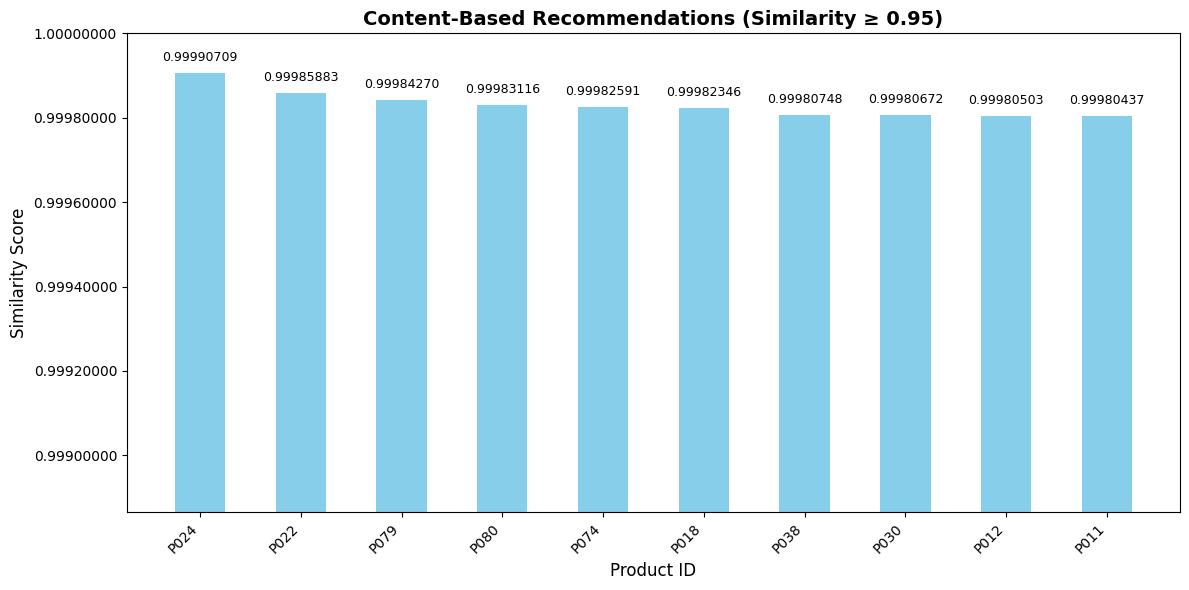

In [197]:
plt.style.use("default")  

if len(content_results) > 0:
    product_ids = []
    similarity_scores = []

    for pid, sim in content_results:
        if sim >= 0.95:
            product_ids.append(pid)
            similarity_scores.append(sim)

    if len(similarity_scores) > 0:
        fig, ax = plt.subplots(figsize=(12, 6))
        bars = ax.bar(product_ids, similarity_scores, color='skyblue', width=0.5)

        ax.set_title("Content-Based Recommendations (Similarity ≥ 0.95)", fontsize=14, fontweight='bold')
        ax.set_ylabel("Similarity Score", fontsize=12)
        ax.set_xlabel("Product ID", fontsize=12)
        ax.set_ylim(0.9988654, 1.0)
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.8f'))

        plt.xticks(rotation=45, ha='right', fontsize=10)

        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.00002,
                f"{height:.8f}",
                ha='center',
                va='bottom',
                fontsize=9
            )

        plt.tight_layout()
        plt.show()

In [191]:
print("\nTop Content-Based Recommendations:")
for pair in content_results:
    pid, score = pair
    name = product_df[product_df['Product_ID'] == pid]['Product_Name'].values[0]
    print(f"{pid}: {name} (Similarity: {score:.8f})")

print("\nTop Collaborative Recommendations:")
print(collab_results)

print("\nTop Hybrid Recommendations:")
for i in range(min(10, len(hybrid_ids))):
    pid = hybrid_ids[i]
    name = product_df[product_df['Product_ID'] == pid]['Product_Name'].values[0]
    print(f"{pid}: {name}")


Top Content-Based Recommendations:
P024: Green Tea Capsule - Patanjali (Similarity: 0.99990709)
P022: Tulsi Tea Bags - Khadi Naturals (Similarity: 0.99985883)
P079: Amla Soap - Nature's Gold (Similarity: 0.99984270)
P080: Ashwagandha Baked - Patanjali (Similarity: 0.99983116)
P074: Aloe Vera Soap - Khadi Naturals (Similarity: 0.99982591)
P018: Tulsi Paste - Nourish You (Similarity: 0.99982346)
P038: Turmeric Oil - Himalaya (Similarity: 0.99980748)
P030: Aloe Vera Gel - Nourish You (Similarity: 0.99980672)
P012: Honey Oil - Organic India (Similarity: 0.99980503)
P011: Jaggery Tea Bags - Organic Valley (Similarity: 0.99980437)

Top Collaborative Recommendations:
['P027', 'P008', 'P022', 'P003', 'P004', 'P006', 'P001', 'P040', 'P031', 'P038', 'P009', 'P017', 'P026', 'P014', 'P025', 'P018', 'P007', 'P039', 'P030', 'P035', 'P023', 'P012', 'P011', 'P036', 'P028', 'P019', 'P037']

Top Hybrid Recommendations:
P022: Tulsi Tea Bags - Khadi Naturals
P018: Tulsi Paste - Nourish You
P038: Turmeric